# Basics of Mobile Robotics (BOMR) Report

## Introduction 

The Thymio robot has to get up everyday to deliver his loafs of bread to his customers. One day, he asked Group 44 of the BOMR class some help !
With the help of their instructor prof. Mondada and the army of TAs, the group of students managed to quickly propose a solution to make the bread delivery as efficient as possible !

As part of the "Basics of Mobile Robotics" course project by Professor Mondada, this project aims at creating a complete mobile robotics pipeline on the Thymio robot. In this sence, the robot has to navigate a map to deliver his loafs to his customers, located on the red circles. During this mission, it must avoid obstacles and find the path that minimizes his delivery. To achieve this, the project has been organised in four parts 

- Global Vision
- Path Planning
- Motion Control 
- Pose estimation

## Group members 

1. **Anthony Kalaydjian** 
    - Study : MA3 - Computer Science & Applied Mathematics @ ENSTA Paris
2. **Francis Pannatier** 
    - Study : MA1 - Robotics
3. **George Petran** 
    - Study : MA1 - Robotics 
4. **Johanne Pinel** 
    - Study : MA1 - Robotics 

## Setup 

Map :


- Red point represents objectives
- Black elements represents obstacles
- Local obstacles can also occur in the form of cylinders
- Aruco markers serve as boundaries for the map and to detect the Thymio.

![Alt Text](assets/videos/video.gif)

## Part 1 - Computer Vision
Most of the operations regarding computer vision are also documented withing the functions themselves in [vision.py](src/vision.py) so we will not go into much detail here.
| Functionality                                   | Description                                                                                  |
|------------------------------------------------|-----------------------------------------------------------------------------------------------|
| Calibrating perspective (Bird's Eye View)      | Fixing the perspective of the camera to have a flat plane                                     |
| Finding the robot's position                   | Locates the robot's position using its Aruco code.                                            |
| Finding camera-visible obstacles               | Detects black polygons representing obstacles without detecting the robot as  an obstacle     |
| Finding the goals                              | Identifies red circles representing the objectives that need to be reached.                   |

In [1]:
import matplotlib.pyplot as plt
import json
import sys
import cv2
import numpy as np
import sys
sys.path.append(".")
from utils.aruco_generation import generate_aruco

%load_ext autoreload
%autoreload 2

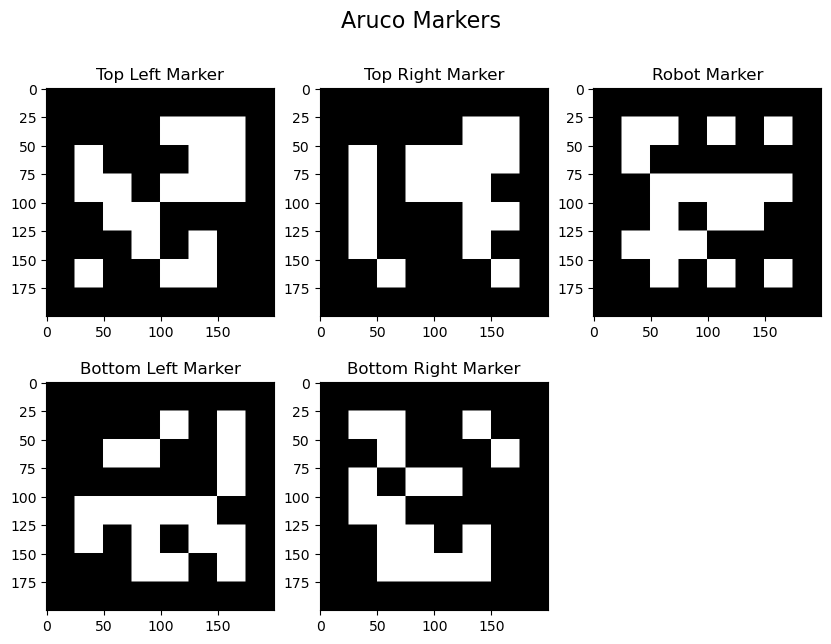

In [2]:
marker_size = 200
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

top_left_marker     = generate_aruco(0, marker_size, aruco_dict)
top_right_marker    = generate_aruco(1, marker_size, aruco_dict)
bottom_left_marker  = generate_aruco(2, marker_size, aruco_dict)
bottom_right_marker = generate_aruco(3, marker_size, aruco_dict)
robot_marker        = generate_aruco(4, marker_size, aruco_dict)

# create an image viewer where i can scroll through the markers
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes[0, 0].imshow(top_left_marker, cmap='gray')
axes[0, 0].set_title('Top Left Marker')
axes[0, 1].imshow(top_right_marker, cmap='gray')
axes[0, 1].set_title('Top Right Marker')
axes[1, 0].imshow(bottom_left_marker, cmap='gray')
axes[1, 0].set_title('Bottom Left Marker')
axes[1, 1].imshow(bottom_right_marker, cmap='gray')
axes[1, 1].set_title('Bottom Right Marker')
axes[0, 2].imshow(robot_marker, cmap='gray')
axes[0, 2].set_title('Robot Marker')
axes[1, 2].axis('off')

fig.suptitle('Aruco Markers', fontsize=16)

plt.show()

We will use 4 markers to create the delimiations of the map.
The fifth marker will be used to locate the robot.

### Marker detection

Now let's see the marker detection in action:

First we need to define the informations about the markers that we are using

In [3]:
from src.vision import VisionDetector

aruco_info = json.load(open('assets/aruco/state.json', 'r'))
aruco_info

{'aruco_dict': 'DICT_6X6_250',
 'marker_size': 200,
 'top_left_id': 0,
 'top_right_id': 1,
 'bottom_left_id': 2,
 'bottom_right_id': 3,
 'robot_id': 4}

Text(0.5, 1.0, 'Original Image')

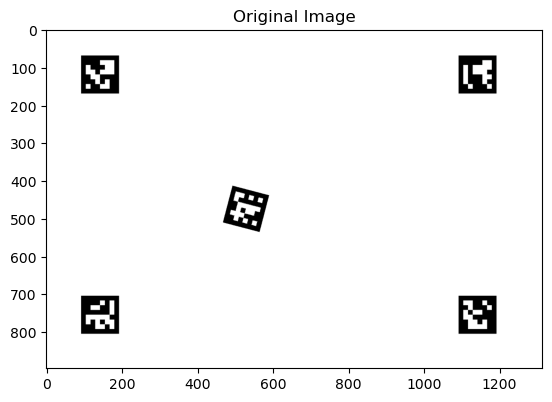

In [4]:
og_image = cv2.imread('assets/additional/aruco_board.png')
plt.imshow(og_image)
plt.title('Original Image')

We are able to locate the different aruco markers and their ids! We can also determine the position of the corners of the markers.

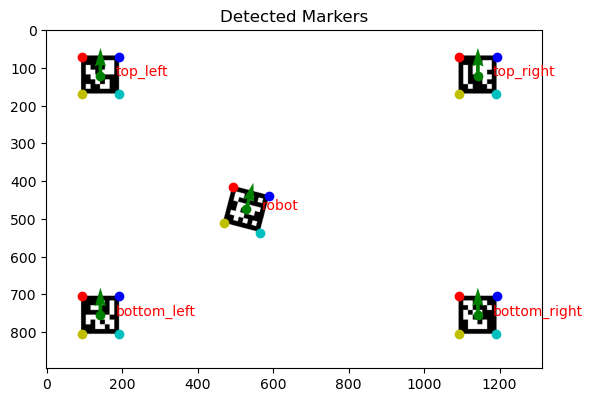

In [5]:
detector = VisionDetector(og_image, (1100, 700), **aruco_info)
marker_data = detector._detect_aruco(og_image)

# plot the detected markers
plt.imshow(og_image)
for i, marker in marker_data.items():
    plt.plot(marker["center"][0], marker["center"][1], 'go')
    plt.text(marker["center"][0] + 40, marker["center"][1], i, color='red')
    plt.plot(marker["corners"][0, 0], marker["corners"][0, 1], 'ro')
    plt.plot(marker["corners"][1, 0], marker["corners"][1, 1], 'bo')
    plt.plot(marker["corners"][2, 0], marker["corners"][2, 1], 'co')
    plt.plot(marker["corners"][3, 0], marker["corners"][3, 1], 'yo')
    orientation = marker["orientation"]
    center = marker["center"]
    plt.quiver(center[0], center[1], orientation[0], -orientation[1], color='green')
    plt.title('Detected Markers')
plt.show()

### Calibrating Perspective

Now that we know how to detect the Aruco markers, we can use some linear algebra to resolve the perspective issue. This is done by measuring the positions of the 4 corner points of the image that we locate thanks to the markers, and map them to an undistorted shape.

Text(0.5, 1.0, 'Image with a perspective transformation')

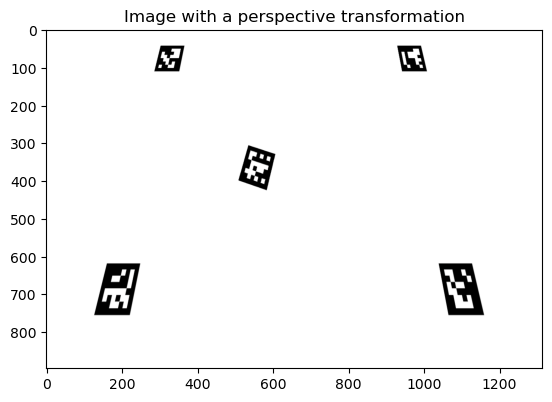

In [6]:
og_image = cv2.imread('assets/additional/aruco_board_perspective.png')
plt.imshow(og_image)
plt.title('Image with a perspective transformation')

Given a target map size that we know in advance, we can fix the perspective and crop the image to the desired shape.

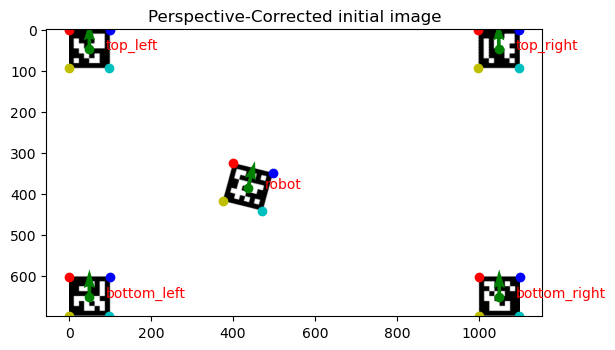

In [7]:
detector = VisionDetector(og_image, (1100, 700), **aruco_info)
image = detector.get_corrected_image(og_image)
plt.imshow(image)
for i, marker in detector.transformed_aruco_state.items():
    plt.plot(marker["center"][0], marker["center"][1], 'go')
    plt.text(marker["center"][0] + 40, marker["center"][1], i, color='red')
    plt.plot(marker["corners"][0, 0], marker["corners"][0, 1], 'ro')
    plt.plot(marker["corners"][1, 0], marker["corners"][1, 1], 'bo')
    plt.plot(marker["corners"][2, 0], marker["corners"][2, 1], 'co')
    plt.plot(marker["corners"][3, 0], marker["corners"][3, 1], 'yo')
    orientation = marker["orientation"]
    plt.quiver(marker["center"][0], marker["center"][1], orientation[0], -orientation[1], color='green')
    plt.title('Perspective-Corrected initial image')
plt.show()

In [8]:
import inspect
print(inspect.getsource(VisionDetector.get_corrected_image))

    def get_corrected_image(self, image, hide_aruco=False):
        """
        Get the cropped image after the perspective correction.
        """
        assert self.perspective_transform is not None, "Perspective transform is not initialized. Call correct_perspective first."
        
        corrected_image = cv2.warpPerspective(image, self.perspective_transform, (self.map_size[0], self.map_size[1]), borderValue=255)

        if hide_aruco:
            # set the corners to white
            for marker in self.transformed_aruco_state.values():
                cv2.fillPoly(corrected_image, [marker["corners"].astype(np.int32)], (255, 255, 255))

        return corrected_image



### Finding Obstacles (Black Polygons)
The CV algorithm converts the BGR image to GrayScale and detects contours using cv2.findContours and black-to-white thresholding and returning only the points that reprezent the convexHull. (more detailed explanation in [vision.py](src/vision.py) )

In [9]:
print(inspect.getsource(VisionDetector.find_polygons))

    def find_polygons(self, image: np.ndarray, border_size=1, min_area=200, thresh_1 = 127, thresh_2 = 255):
        # code from https://www.geeksforgeeks.org/how-to-detect-shapes-in-images-in-python-using-opencv/

        # converting image into grayscale image 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

        # setting threshold of gray image 
        _, threshold = cv2.threshold(gray, thresh_1, thresh_2, cv2.THRESH_BINARY) 

        # using a findContours() function 
        contours, _ = cv2.findContours( 
            threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

        i = 0
        polygon_list = []

        # list for storing names of shapes 
        for contour in contours:
            # Removing all polygons that intersect with the aruco markers
            valid_polygon = True
            for aruco_corners in self.transformed_aruco_state.values():
                corner_points = np.int32(aruco_corners["corners"])
                for point in contour.sq

Let's see a sample of our algorithm :

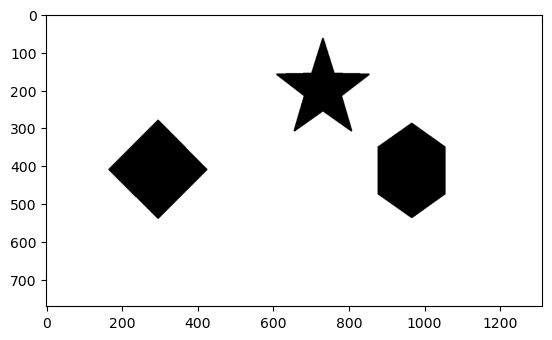

In [10]:
img = cv2.imread('assets/additional/polygons.png')
plt.imshow(img)

Text(0.5, 1.0, 'Detected Polygons')

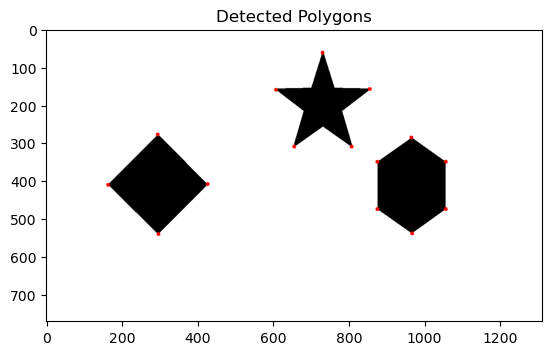

In [11]:
from src.vision import find_polygons
from src.utils import add_polygons, add_robot, add_circles
polygons = find_polygons(img)
polymage = add_polygons(img, polygons)
plt.imshow(cv2.cvtColor(polymage, cv2.COLOR_BGR2RGB))
plt.title('Detected Polygons')

In a real image, we need to mask the robot because it may be detected as an obstacle!

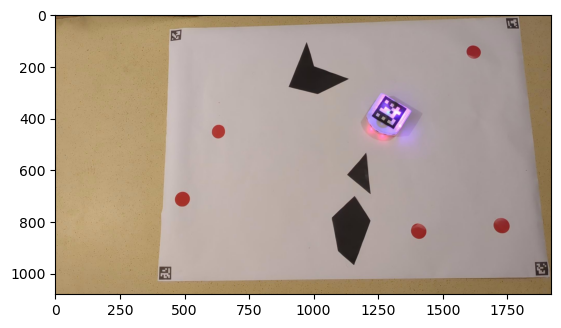

In [12]:
initial_image = cv2.imread('assets/report_pics/computer_vision/test_image.jpg')
map_size = (1179, 830) # (width, height) in mm
detector = VisionDetector(initial_image, map_size)
plt.imshow(cv2.cvtColor(initial_image, cv2.COLOR_BGR2RGB))

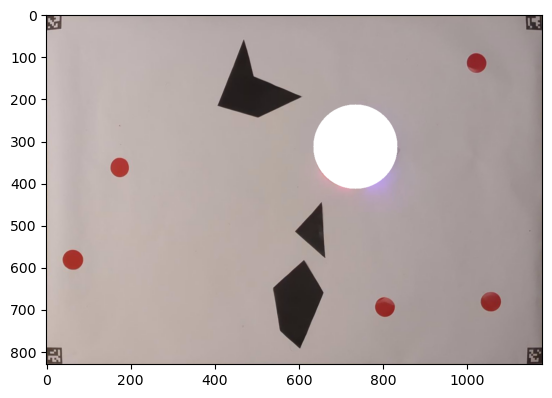

In [13]:
robot_size = 100

corrected_image = detector.get_corrected_image(initial_image)

robot_position_cv, robot_orientation_cv, robot_corners = detector.get_robot_pose(corrected_image, is_corrected=True)

# add a white circle around the robot
hidden_robot_image = cv2.circle(corrected_image.copy(), tuple(robot_position_cv.astype(int)), robot_size, (255, 255, 255), -1)
plt.imshow(cv2.cvtColor(hidden_robot_image, cv2.COLOR_BGR2RGB))

We can now detect the obstacles from this masked image without having false positives around the robot and its shadow

In [14]:
print(inspect.getsource(VisionDetector.find_polygons))

    def find_polygons(self, image: np.ndarray, border_size=1, min_area=200, thresh_1 = 127, thresh_2 = 255):
        # code from https://www.geeksforgeeks.org/how-to-detect-shapes-in-images-in-python-using-opencv/

        # converting image into grayscale image 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

        # setting threshold of gray image 
        _, threshold = cv2.threshold(gray, thresh_1, thresh_2, cv2.THRESH_BINARY) 

        # using a findContours() function 
        contours, _ = cv2.findContours( 
            threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

        i = 0
        polygon_list = []

        # list for storing names of shapes 
        for contour in contours:
            # Removing all polygons that intersect with the aruco markers
            valid_polygon = True
            for aruco_corners in self.transformed_aruco_state.values():
                corner_points = np.int32(aruco_corners["corners"])
                for point in contour.sq

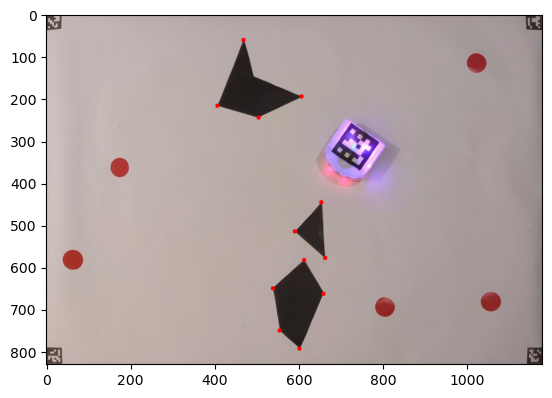

In [15]:
polygons = detector.find_polygons(hidden_robot_image, min_area=200, thresh_1=100, thresh_2=255)
polygon_image = add_polygons(corrected_image, polygons)
plt.imshow(cv2.cvtColor(polygon_image, cv2.COLOR_BGR2RGB))

### Finding the objectives (Red circles)

The detection is based on the Hough Circle Transform. A gradient-based voting scheme that allows to detect circles, even if they are partially occulted ! For our purpose, the objectives will be fully visible, so this is just some bonus information :) !

In [16]:
from src.vision import find_circles
print(inspect.getsource(find_circles))

def find_circles(image, min_radius=1, max_radius=40, thresh1=300, thresh2=30):
    # https://www.geeksforgeeks.org/circle-detection-using-opencv-python/
    
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    
    # Blur using 3 * 3 kernel. 
    gray_blurred = cv2.blur(gray, (3, 3))
    
    # Apply Hough transform on the blurred image. 
    detected_circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, 1, 20, 
                                        param1 = thresh1, 
                                        param2=thresh2,
                                        minRadius=min_radius,
                                        maxRadius=max_radius) 

    return detected_circles



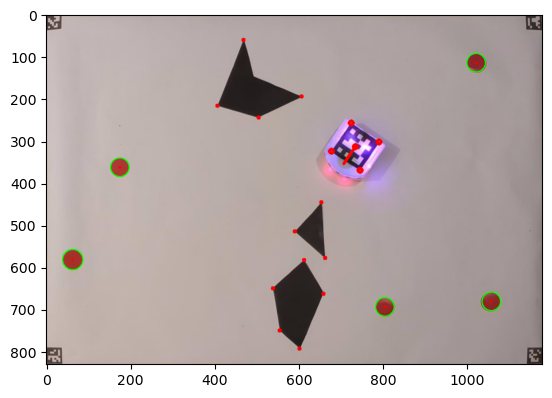

In [17]:
circles = detector.find_circles(polygon_image, 1, 300, 300, 40) #215, 24
circle_positions = circles.squeeze().reshape(-1, 3)[:, :2]
circle_image = add_circles(polygon_image, circles)

image_aruco = add_robot(circle_image, robot_position_cv, robot_orientation_cv, robot_corners)
image_circles = add_circles(image_aruco, circles)

plt.imshow(cv2.cvtColor(image_circles, cv2.COLOR_BGR2RGB))

## Part 2- Path Planning

To present the global navigation pipeline, we will use the following sample image, where the robot is localized by the marker in the center :

<div style="text-align: center;">
    <img src="assets/additional/path_planning.png" alt="Title" width="350"/>
</div>

As you may have noticed, this project is aimed at implementing the Traveling Salesman Problem (TSP). The goal is to retrieve all the objectives while traveling the shortest path.

Let's first lay down some of the preprocessing of the image.

In [18]:
from src.path_planning import create_obstacle_map, path_planning
from src.utils import add_graph, add_route, add_circles, add_polygons, add_point
from src.vision import extend_polygons
import inspect

Here is the image after having corrected the perspective and located the obstacles and targets.

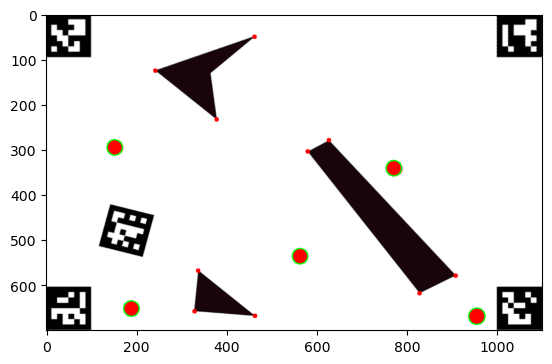

In [19]:
circle_balises = cv2.imread('assets/additional/aruco_balises_circles_perspective.png')
aruco_info = json.load(open('assets/aruco/state.json', 'r'))
detector = VisionDetector(circle_balises, (1100, 700), **aruco_info)
img_corrected = detector.get_corrected_image(circle_balises, hide_aruco=False)
circles = detector.find_circles(img_corrected, 1, 300, 300, 30)
polygons = detector.find_polygons(img_corrected)
processed_image = add_circles(img_corrected, circles)
processed_image = add_polygons(processed_image, polygons)
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))

### Extending Polygons 

We can extend the obstacles by the robot's size to determine the portion of the space where the robot can move without colliding with any global obstacle.

This is done by computing the mean direction of each vertex in a polygon to its neighbouring vertices, and moving of the correct distance in the opposite direction. 

The extension coefficient is approximately equal to half of the Thymio's size in order for it not to collide with obstacles when it moves from one point to another.

<div style="display: flex; justify-content: center; align-items: center;">
    <div style="text-align: center; margin: 10px;">
        <img src="assets/report_pics/Extension 1.png" alt="helloworld" style="width:300px;">
        <p>Illustration of points in a 2D space</p>
    </div>
    <div style="text-align: center; margin: 10px;">
        <img src="assets/report_pics/Extension 2.png" alt="helloworld" style="width:300px;">
        <p>Illustration of the vectors operations</p>
    </div>
</div>

Text(0.5, 1.0, 'Extended polygon global obstacles')

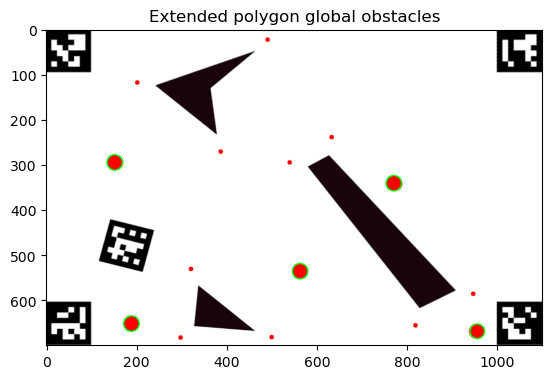

In [20]:
robot_size = 40
polygons, circles = detector.find_shapes(img_corrected, border_size=10)
extended_polygons = extend_polygons(polygons, robot_size)

poly_image = add_polygons(img_corrected, extended_polygons)
circle_image = add_circles(poly_image, circles)
plt.imshow(cv2.cvtColor(circle_image, cv2.COLOR_BGR2RGB))
plt.title("Extended polygon global obstacles")

This allows us to extract an array of keypoints of the map. These keypoints represent the set of polygon vertices, target objective circles and the robot's initial position.

Text(0.5, 1.0, 'Keypoints of the map (in red)')

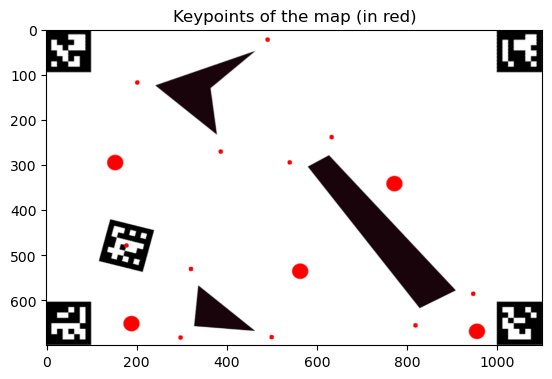

In [21]:
robot_position, _, _ = detector.get_robot_pose(img_corrected, is_corrected=True)
more_circled_img = add_point(poly_image, np.array([robot_position[0], robot_position[1]]))
plt.imshow(cv2.cvtColor(more_circled_img, cv2.COLOR_BGR2RGB))
plt.title("Keypoints of the map (in red)")

To create the optimal path, we will look to create the shortest path linking the robot to all the objectives and exclusively containing straight lines from each joined pair of keypoints.

To compute such a path, we need to create a graph of keypoints where two points are joined by an edge if and only if they are mutually visible, ie the line that joins the two points doesn't get to close to an obstacle.

When an edge exists, we will also need to give it as weight the distance between the two corresponding vertices to have a metric to optimize the path.

### Graph creation

We will mathematically represent the graph as an adjacency matrix $A$, with an index map of the keypoints, keeping track of the indices of the robot and target points.
The matrix $A$ will contain the weights $a_{i, j}$ of each edge. By convention, we will set the weigh to $0$ when the points are not mutually visible.

To create the adjacency matrix of the graph, we loop over all pairs of keypoints, check whether the two points are mutually visible and set the associated value in the adjacency matrix to the distance between the two points.

To check if two points are mutually visible, we will combine:
- The bresenham algorithm: An algorithm that computes the pixel positions of the rasterized line between two given pixels
- An obstacle map: A bitmap of the filled extended polygons.

Two points will be mutually visible if and only if all points on the rasterized line between them are not obstacle points. Because of rasterization which spills on neighbouring pixels, we also decided to not concider the first and last 10 pixels of the line.

Text(0.5, 1.0, 'Obstacle map')

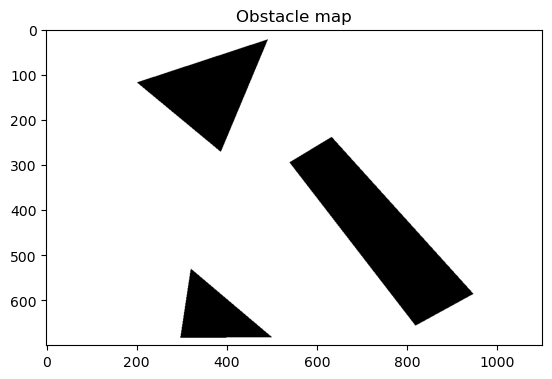

In [22]:
obstacle_map = create_obstacle_map(extended_polygons, img_corrected.shape)
plt.imshow(obstacle_map, cmap='gray')
plt.title("Obstacle map")

Text(0.5, 1.0, 'Visibility check')

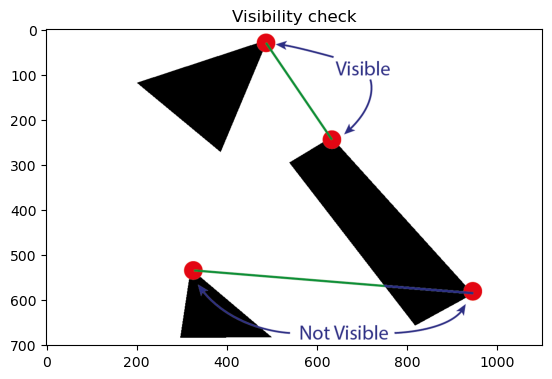

In [23]:
plt.imshow(cv2.cvtColor(cv2.imread("assets/report_pics/computer_vision/visibility.png"), cv2.COLOR_BGR2RGB))
plt.title("Visibility check")

In [24]:
from bresenham import bresenham
from src.path_planning import is_visible
print(inspect.getsource(is_visible))

def is_visible(p1, p2, obstacle_map): 
    """
    This function checks if we can reach p2 from p1 without colliding with the obstacle map.
    We first compute the equation of the line segment between p1 and p2.
    Then we check at each pixel along the line segment if it is part of an obstacle given the obstacle map.
    """
    # check if p1 and p2 are inside of the map
    if not in_image(p1, obstacle_map) or not in_image(p2, obstacle_map):
        return False
    
    line = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
    line = line[10:-10] # remove the start and end points
    for point in line:
        if obstacle_map[point[1], point[0]] == 0:
            return False
    
    return True



Text(0.5, 1.0, 'Bresenham rasterized line between two points')

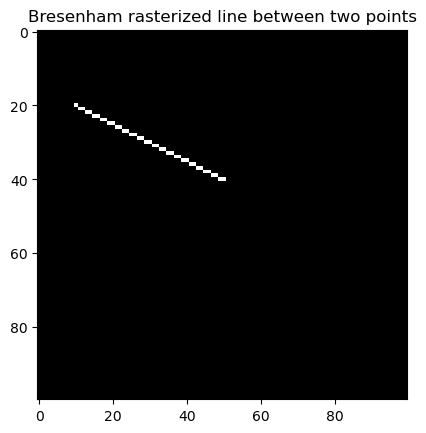

In [25]:
# plot a line between two points
new_image = np.zeros((100, 100))
p1 = (10, 20)
p2 = (50, 40)
line = bresenham(*p1, *p2)
for x, y in line:
    new_image[y, x] = 1
plt.imshow(new_image, cmap='gray')
plt.title('Bresenham rasterized line between two points')

In [26]:
from src.path_planning import create_adjacency_matrix_pts
print(inspect.getsource(create_adjacency_matrix_pts))

def create_adjacency_matrix_pts(points, obstacle_map):
    """
    Creates an adjacency matrix for the graph formed by the points.
    If the points are visible to each other, then the edge value is the euclidean distance between the points.
    Otherwise, their is no edge between the points.
    """
    n = points.shape[0]
    adjacency_matrix = np.zeros((n, n))

    l = np.arange(n)

    for n1 in range(len(points)):
        for n2 in range(n1+1, len(points)):
            p1 = points[n1]
            p2 = points[n2]
            if is_visible(p1, p2, obstacle_map):
                edge_value = np.linalg.norm(p1 - p2)
                adjacency_matrix[n1, n2] = edge_value
                adjacency_matrix[n2, n1] = edge_value
    return adjacency_matrix



In practice, the adjacency matrix will be computed in two steps.
1. The first step is to run the previous strategy between all pair of points. But this strategy won't include any line segment that spans across the obstacle polygon's vertices, although it is a valid edge, the visibility check will detect obstacles.
2. The second step is therefore to add the edges of each polygons into the adjacency matrix. But we must be careful when doing so as these edges could cross an other polygon's extention. Therefore, the strategy that is employed is to recompute, for each polygon, a new obstacle map not containing that polygon and adding the edge to the adjacency matrix only if the edge vertices are visible in the new obstacle map.

Here is the implementation of the full adjacency matrix pipeline:

In [27]:
from src.path_planning import create_adjacency_matrix
print(inspect.getsource(create_adjacency_matrix))

def create_adjacency_matrix(polygons, start_position, key_points, img_shape):
    """
    Creates an adjacency matrix for the graph formed by the points in the polygons. Note that here, we may use this function with the
    polygons as well as the start position, and key points.
    The adjacency matrix is created by connecting the points which are visible.
    """
    poly_list = polygons.copy()
    poly_list.append(start_position[None, None, :])
    poly_list.extend([kp[None, None, :] for kp in key_points])

    obstacle_map = create_obstacle_map(poly_list, img_shape)
    points = [[*polygon.squeeze(1)] for polygon in poly_list]
    points = np.concatenate(points)

    adjacency_matrix = create_adjacency_matrix_pts(points, obstacle_map)
    
    # adding edges of polygons to the adjacency matrix
    n_buffer = 0
    for n_poly, polygon in enumerate(polygons):
        polygon = polygon.squeeze(1)
        n = polygon.shape[0]
        for i in range(n):
            if not in_image(polyg

We can display the complete adjacency graph, which we will explore to compute the shortest path collecting all objectives from the robot's initial position

Text(0.5, 1.0, 'Graph of the map')

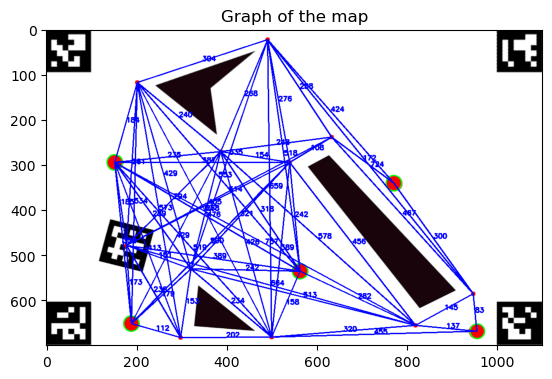

In [28]:
polygons = detector.find_polygons(img_corrected)
extended_polygons = extend_polygons(polygons, robot_size)
robot_position, _, _ = detector.get_robot_pose(img_corrected, is_corrected=True)
circles = detector.find_circles(img_corrected, 1, 300, 300, 30)
circle_positions = circles.squeeze()[:, :2]
img_shape = img_corrected.shape[:2]
adjacency_matrix, points = create_adjacency_matrix(extended_polygons, robot_position, circle_positions, img_shape)

graph_image = add_graph(circle_image, np.uint32(points), adjacency_matrix, color=(255, 0, 0))
plt.imshow(cv2.cvtColor(graph_image, cv2.COLOR_BGR2RGB))
plt.title('Graph of the map')

### Shortest path computation 

The shortest path is computed in two steps.

1. We start by creating a dictionary, whose keys are pairs of circle targets, as well as the robot. For each key, we will compute, in the adjacency matrix that we created, the shortest path between the two points. The dictionary values may contain the length of the path as well as the sequence of vertex ids that represent the path. This step is executed using Dijkstra's algorithm.
2.  Once this is computed, our goal is to find the shortest path that visits all the keypoints from the start position.
We can loop over all possible permutations of the objectives, compute the cost of the associated paths, as the sum of the lengths of successive pairs in the permutation.
The final cost must also include the cost of going from the start position to the first keypoint. To this cost, we add the cost of going from the robot to the first objective.
We then select the path with the minimum cost.
The final path will be te concatenation of the successive shortest paths between each target.

Although this method is brute force, it gives us the optimal path and works perfectly in real time for our usecase as the number of keypoints and targets is small. 

In [29]:
from src.path_planning import path_planning
print(inspect.getsource(path_planning))

def path_planning(start_position, key_points, polygons, img_shape=(700, 1100)):
    """
    Brute force algorithm to solve the TSP problem.
    This algorithm works in two parts. We first start by computing the shortest path between each pair of points in {start position, key points}
    that make use of the full adjacency graph comprising of the {start position, key points, polygon points}.
    This gives us a dictionary of shortest paths and their associated costs between each pair of nodes we need to visit.
    Once this is computed, our goal is to find the shortest path that visits all the key points from the start position.
    We can loop over all possible permutations of the key points, compute the cost of each associated path, as the sum of the costs of each pair of points in the path.
    The final cost must also include the cost of going from the start position to the first key point.
    We then select the path with the minimum cost.
    """
    # inspired from https://mediu

Text(0.5, 1.0, 'Optimal route')

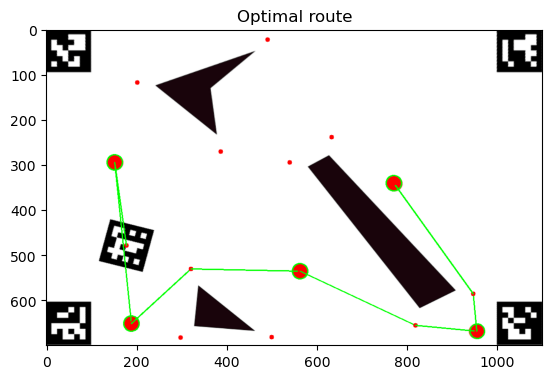

In [30]:
optimal_route, optimal_route_positions, points, adjacency_matrix = path_planning(robot_position, circle_positions, extended_polygons, processed_image.shape)
route_image = add_route(circle_image, np.int32(optimal_route_positions))
plt.imshow(cv2.cvtColor(route_image, cv2.COLOR_BGR2RGB))
plt.title('Optimal route')

We can also take a look at the optimal path with the obstacle map, and convince ourselves that it is indeed the shortest possible path that reaches all targets!

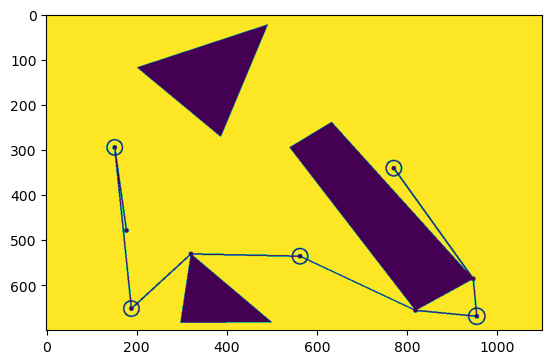

In [31]:
obstacle_map = create_obstacle_map(extended_polygons, processed_image.shape)
circled = add_circles(obstacle_map, circles)
route_image = add_route(circled, np.int32(optimal_route_positions))
plt.imshow(circled)

## Part 3 - Motion Control

Motion control is an essential part for the project of mobile robotics. Its goal is to give instruction to the robot in order to make it move the way it should. The instructions are a result of the entire program. For example, the global path planning will give a route that the robot will have to follow. Using it, it needs a controller with those informations to make the Thymio follow the path. In order to do that, several functions are needed to make geometrical computations. That is the purpose of the [Geometry.py](src/geometry.py) script.

### Geomtery.py
#### Axes

Using cv2 for the vison part creates images using vectors which y axes pointing downward, as in the image processing convention. In order to simplify the geometric calculations, all position and vectors will be transported in the classical mathematical convention, with y pointing upwards. This is especially important when computing angles, as their sign would change depending on the y axis' orientation.

<div style="text-align: center;">
    <img src="assets/report_pics/navigation/Axe_cv_m.png" alt="helloworld" style="width:500px;">
    <p style="text-align: center;">Illustration of the x/y axes according to the reference frame </p>

</div>

In order to change conventions, we use the following two functions:

In [ ]:
import inspect
from src.geometry import convert_points, convert_vec
from src.navigation import FSMController

print(inspect.getsource(convert_points))
print(inspect.getsource(convert_vec))


def convert_points(points, y_max):
    if len(points.shape) == 1:
        return np.array([points[0], y_max - points[1]])
    converted_points = np.stack((points[:, 0], y_max - points[:, 1]), axis=-1)
    return converted_points

def convert_vec(vec):
    if len(vec.shape) == 1:
        return np.array([vec[0],-vec[1]])
    converted_vec = np.stack((vec[:, 0], -vec[:, 1]), axis=-1)
    return converted_vec



Note that this convertion works in both directions such that when the input of one of the two function is in the CV axis, the output will be in math axes, and vice versa!

#### Other functions

| functions                | Description                                      | 
|-------------------------|--------------------------------------------------|
| `define_line_p(point1,point2)`          | Create a dictionary with a point and a direction vector             
| `dir_to_line(point, droite)`          | Generate the vector from a point to its projection on a line        
| `get_angle(v1,v2)`        | Take two vectors and calculate the angle between them     
| `convert_angle_to_vector(angle)`        | Take an angle and generate a unit vector 

### Class FSMController
In the script [navigation.py](src/navigation.py), a class named FSMController was made. The purpose of the class is to generate the instructions for the robot. There is 3 different axes in the class. The first one is the FSM. Its purpose is to generate the state of the robot to know if it needs to follow, the path, avoid a local obstacle or go back on the line. Each one of these states have their own controller. 
The second one is the "change target module". Its purpose is to verify if a target has been reached, to change target if it's the case and to verify if the last goal has been reached.
And the final part is the calculation of the different controllers using the informations from the camera and the different geometrical operations. 

We will first describe the varaibles that are stored in the class. It is useful to note that all the element are stored in math coordinate system.

#### Variables
| Variables                | Description                                      | 
|-------------------------|--------------------------------------------------|
| `previous_target`          | The point the robot has just reached          
| `all_target_m`          | Array containing the point in the right order the robot needs to reach in order to follow the path 
| `objectives_m`          | Array containing the objectives the robot needs to collect
| `current_target`          | The next point the robot wants to reach
| `path_m`          | The line the robot is suppose to follow to reach the next target
| `first_prox`          | The first sensor activated when an obstacle is on the path of the robot
| `state`          | The state for the FSM
| `intensity`          | Intensity of the leds
| `prox_obstacle_threshold`          | The distance from path indicating the robot has to look for the path after the obstacle avoidance
| `img_shape`          | The purpose of this variable is to help recalculate path when the robot avoid an obstacle
| `extended_polygons`          | The purpose of this variable is to help recalculate path when the robot avoid an obstacle


### Final State Machine
The following picture shows the FSM, with it's different states, and conditions.

<div style="text-align: center;">
    <img src="assets/report_pics/navigation/FSM_final.png" alt="helloworld" style="width:600px;">
    <p style="text-align: center;">Illustration of the FSM for the Motion Control </p>
</div>

The big colored squares shows the different state of the FSM. The colour are matching the colours of the leds when in the corresponding state. The red squares shows the different conditions to switch from a state to an other.

The FSM was the most direct way for the navigation. Indeed, we thought that the robot only has two possibilities: It follows the path, or it avoid an obstacle.
The first state is the global navigation. The robot is supposed to follow the line named `path_m` until one of the prox sensor is activated. Then the robot goes in green state and it avoid the obstacle.
In front of an obstacle the robot will turn untill the prox are blind again because not in front of the obstacle any more. In that case the robot will travel straight ahead untill the robot is far enough from the global path. Then it will recalculate path when it comes back to state 0 and follow it.

The following code is the function that update the state of the FSM.
Note thate:
 State value in the code                | State colour on schema                                      | 
|-------------------------|--------------------------------------------------|
| `0`          | Purple
| `1`          | Green


In [ ]:
print(inspect.getsource(FSMController.update_state))

    def update_state(self, dist_robot_line, robot_pos, prox):
        
        #go to state 1 (obstacle avoidance) if a prox sensor is activated
        if self.state==0 and (np.sum(prox) != 0):
            self.state=1
            #define which prox sensor is activated first
            self.first_prox = np.argmax(prox)

        #go to state 0 (follow line) if the distance to path is large enough and recompute the global route
        elif self.state==1 and (dist_robot_line > self.prox_obstacle_threshold):
            self.state = 0
            self.recompute_global_path(robot_pos)



#### Controllers
For the motion, we choosed to make controllers in order to have smooth movements for the robot and real time adaptation with the environment. The advantage of controller is that you can just tell the robot: "Follow the line!" and if there is a line, it will follow it. It avoid making big function with an endless list of "if". For this project, 3 different controllers were used.

#### 1. *global_control_angle(self, robot_orientation)*

This is one of the two controllers that manage the global navigation. It's purpose is to find the angle beetween the direction vector of the line `path_m` and the `robot_orientation`. The robot will then travel in the right direction according to the following diagram:

<div style="text-align: center;">
    <img src="assets/report_pics/navigation/controle_angle.png" alt="hellowold" style="width:500px;">
    <p style="text-align: center;">Illustration of the angle control </p>

</div>

This idea came from the fact that the robot is supposed to follow the line and not to follow the target. Indeed, if it follows the target and is far from the line, the trajectory would not follow the `path_m` and could cross an obstacle. Nevertheless, in both case the robot needs a second cotroller to know if it's on the line or not.

The regulator is implemented in the next cell. We can see that the regulator is proportionnal to the angle in degrees. Seeing the value of previous regulator we did during the exercice session, the values matches more with degrees than radians. Obviously we could have made a regulator with radians but the `GLOBAL_GAIN_ANGLE` would have been much bigger. In the case of degrees, we choosed `GLOBAL_GAIN_ANGLE` = `1.7`
At first it was set to 2 but when it was implemented with `global_control_path(...)`, it had to be decreased.

In [ ]:
print(inspect.getsource(FSMController.global_control_angle))

    def global_control_angle(self, robot_orientation):

        v_dir = self.path_m["v_dir"]

        #calculate the angle between the robot and the direction of the path
        robot_to_vdir_angle = get_angle(robot_orientation, v_dir)
        
        #define speed
        speed_regulator = GLOBAL_GAIN_ANGLE * np.degrees(robot_to_vdir_angle)
        
        return speed_regulator



#### 2. *global_control_path(self, vec_robot_to_path, robot_orientation)*
The purpose of this controller is to make the robot stay on a line. In this case, on `path_m`. It was thougt to use only this one as controller for global navigation but the idea was bad because the robot would not know the direction of the next target. On the following picture is a representation of the controller idea.


<div style="text-align: center;">
    <img src="assets/report_pics/navigation/controle_path.png" alt="control p" style="width:500px;">
    <p style="text-align: center;">Illustration of the control path </p>
</div>

This controller take the distance beetween the robot and its projection on the line and make the controller proportionnal to it. So the further the robot is from `path_m`, the more it will turn to go back on the line. The sign of the angle between `robot_orientation` and `vec_robot_to_path` give the direction the robot has to choose to turn.


In [ ]:
print(inspect.getsource(FSMController.global_control_path))

    def global_control_path(self, vec_robot_to_path, robot_orientation):
        
        #calculation angle from the robot orientation to the projection on the path
        robot_to_path_angle = get_angle(robot_orientation, vec_robot_to_path)  
        
        controller = CONTROL_GAIN_PATH * np.sign(robot_to_path_angle) * np.linalg.norm(vec_robot_to_path)
        
        return controller



`global_control_path` and `global_control_angle` work together for the global navigation with different weight through the function `global_control(self, vec_robot_to_path, robot_orientation)`. The gain were choosen first alone and then together. It implied several tests but most of the work were made with separated tuning.


#### 3. *local_control(self, prox, vec_robot_to_path, dist_robot_line)*
This controller is made to avoid a local obstacle put on the path. In order to have a better control, the `speed` decreases. Then the robot choose the direction it is suppose to avoid the obstacle. When the robot is on the left side of `path_m` , it avoid the obstacle by left and when on the right side it avoid by right when the first prox sensor activated is the number two. It was added later on because of the small overshoot of the robot when it follows the line. When the sensor saw the obstacle, it could want to avoid it making the longer circle despite of the small one. So to avoid this kind of problem, the value `first_prox` represent the indice of the first sensor that has detected an obstacle. This value comes from the function: `update_state()` because the condition to get it is the following: The first prox is activated when the FSM goes from state 0 to 1.



Sometime, when looking for the path, the robot touches the obstacle because the obstacle is a circle and the prox sensors 0 and 4 have difficulties to see it because of their orientation on the robot. 
Once the weight have been decided, the controller take all the sensors and find the best way to avoid it. If it's the result of the scalar product crating `control` is negativ, it'll turn right and so on. 


In [ ]:
print(inspect.getsource(FSMController.local_control))

    def global_control(self, vec_robot_to_path, robot_orientation):
        
        speed = 150
        #mix the controller with angle of the path and distance from path
        controller = self.global_control_angle(self.path_m, robot_orientation)
        controller += self.global_control_path(vec_robot_to_path, robot_orientation)

        #avoid variable conversion problem with float and int
        if math.isnan(controller):
            speed_left = 0
            speed_right = 0
        else:
            speed_left = speed - int(controller)
            speed_right = speed + int(controller)
        
        return speed_left, speed_right



#### 4. *change_target(self, robot_pos_m)*
The purpose of this function is to calculate the new path once a target is reached, to make the program know if the last objectiv is reached in order to live the loop if so and to update the variables used in the class.
To know if a target is reached, we put a threshold in order to smooth the robot movement and avoid a bit of overshoot since the path is made of angles.

Variable update                | Manner                                     | 
|-------------------------|--------------------------------------------------|
| `all_target_m`          | The current target, always the first element of the array, is removed
| `previous_target`          | Becomes the `current_target`
| `current_target`          | becomes the first element of `all_target_m` 
| `objectives_m`          | Remove the objective that is previous target
| `path_m`          | Recalculate using current and previous target

We choosed to remove the objectives reached in `objectives_m` in order to ensure the robot does not want to take an objectives twice when recalculating path.


In [ ]:
print(inspect.getsource(FSMController.change_target))

    def change_target(self, robot_pos_m):

        stop = 0
        target_reach_threshold = 80
        
        #calculate distance to target
        distance_to_target = np.linalg.norm(robot_pos_m - self.current_target)

        #if closed enough to target
        if(distance_to_target < target_reach_threshold):

            #if the list of target is empty, all target are reached
            if len(self.all_target_m) > 1:

                #remove the target that has just been reached
                self.all_target_m = self.all_target_m[1:, :]
                if len(self.all_target_m) == 1:
                    # si il ne reste plus que le dernier point, on réduit le threshold pour s'arrêter dessus
                    target_reach_threshold = 25

                #initialize the new target
                self.previous_target = self.current_target.copy()
                self.current_target[:] = self.all_target_m[0, :]
                
                # modifiy circles (objectives) list

#### 5. *get_command(self, prox, robot_pos, robot_orientation)*

This function is the only one called in the main loop. All the previous function are called in it and the only values `get_command(...)` needs are the `robot_position` in math, the `robot_orientation` in maths and the prox values. 
The way it works is the following: First it chooses the right state, then it gets the good controller and set the led intensity, verifiy if it needs to change target or if it's the end of the path and return the instructions for the motor, the leds and the indication `stop` if it's the end of the program.

In [ ]:
print(inspect.getsource(FSMController.get_command))

    def get_command(self, prox, robot_pos, robot_orientation):

        vec_robot_to_path = dir_to_line(robot_pos, self.path_m)
        dist_robot_line = np.linalg.norm(vec_robot_to_path)
        
        speed_left, speed_right = 0, 0

        self.update_state(dist_robot_line, robot_pos, prox)

        if self.state==0:
            leds_top = [self.intensity, 0, self.intensity]
            #use global controller with the mix of vector of path and distance to path
            speed_left, speed_right = self.global_control(vec_robot_to_path, robot_orientation)
        if self.state==1:
            leds_top = [0, self.intensity, 0]
            #use local control using the prox values
            speed_left, speed_right = self.local_control(prox, vec_robot_to_path, dist_robot_line)

        #try to change target and verify if all the target are reached
        stop = self.change_target(robot_pos)

        return leds_top, speed_left, speed_right, stop



## Part 5 - Kalman Filter 

As part of the "Basics of Mobile Robotics" course project, accurately tracking the position of the Thymio robot during its movement on the map is essential. The Extended Kalman Filter (EKF) is applied due to the nonlinear nature of the robot's motion and sensor models, which involve trigonometric calculations and noisy camera measurements. The EKF linearizes these models at each time step, providing reliable state estimation despite uncertainties in controls and observations. This makes it well-suited for robot tracking tasks, including Thymio's localization.

The `KalmanFilter` class implements an Extended Kalman Filter (EKF) to estimate the position and orientation of the Thymio robot by fusing motion commands with position measurements obtained from a camera. The implementation follows two main steps: **prediction** and **update**. Below, we describe and justify the design choices made for the Kalman Filter.

#### Initialization 
The filter initializes the robot's state based on its first camera-based position measurement. The covariance matrix is updated to reflect the uncertainty in the initial state. For this project, the robot's state includes:

- *x*: The robot's x-coordinate.
- *y*: The robot's y-coordinate.
- *$\theta$*: The robot's orientation relative to the x and y axes.

In matrix form, the state is represented as:
$$
\mathbf{x}_{k} = 
\begin{bmatrix}
x_k \\
y_k \\
\theta_k
\end{bmatrix}
$$

The state transition model is expressed as:
$$
\mathbf{x}_{k} = \mathbf{A} \mathbf{x}_{k-1} + \mathbf{B} \mathbf{u}_{k},
$$

where:
$$
\mathbf{A} = \mathbf{I}_{3 \times 3} = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix},
$$
$$
\mathbf{B}(\theta, \Delta t) = \Delta t \cdot 
\begin{bmatrix}
0.5 \cos(\theta) & 0.5 \cos(\theta) \\
0.5 \sin(\theta) & 0.5 \sin(\theta) \\
-\frac{1}{\text{DIST\_WHEEL}} & \frac{1}{\text{DIST\_WHEEL}}
\end{bmatrix},
$$

and $\mathbf{u}_{k}$ is the control input vector for motor speeds.

The parameters and matrices of the model are initialized as follows:

| Variable                | Description                                      |
|-------------------------|--------------------------------------------------|
| `A`                    | State transition matrix                          |
| `H`                    | Observation matrix                               |
| `Q` & `R`              | Covariance matrices for process and measurement noise |
| `dt`                   | Time step                                        |
| `DIST_WHEEL`           | Distance between the robot's wheels             |

The matrices `Q` and `R` were calibrated through testing to optimize filter performance. The matrix `A` is the identity matrix because the robot's motion model assumes that the state variables ($x$, $y$, $\theta$) remain constant in the absence of external controls, simplifying state transitions.

#### Prediction
The prediction step estimates the robot's state and its covariance at time *k* based on values from time *k−1*. The `prediction` function uses the control matrix `B` to project changes in position and orientation based on motor inputs. The process uncertainty (`Q`) and the previous covariance are incorporated to refine the prediction. The equations for prediction are:
$$
\mathbf{x}_{k}^{-} = \mathbf{A} \mathbf{x}_{k-1} + \mathbf{B} \mathbf{u}_{k},
$$
$$
\mathbf{P}_{k}^{-} = \mathbf{A} \mathbf{P}_{k-1} \mathbf{A}^{T} + \mathbf{Q},
$$

#### Update
The update step corrects the prediction by incorporating sensor measurements. The innovation (measurement residual) is calculated, followed by the Kalman gain. The estimated state and covariance are updated based on the measurement noise (`R`) and the predicted covariance. The equations for the update step are:
$$
\mathbf{y}_{k} = \mathbf{z}_{k} - \mathbf{H} \mathbf{x}_{k}^{-},
$$
$$
\mathbf{S}_{k} = \mathbf{H} \mathbf{P}_{k}^{-} \mathbf{H}^{T} + \mathbf{R},
$$
$$
\mathbf{K}_{k} = \mathbf{P}_{k}^{-} \mathbf{H}^{T} \mathbf{S}_{k}^{-1},
$$
$$
\mathbf{x}_{k} = \mathbf{x}_{k}^{-} + \mathbf{K}_{k} \mathbf{y}_{k},
$$
$$
\mathbf{P}_{k} = (\mathbf{I} - \mathbf{K}_{k} \mathbf{H}) \mathbf{P}_{k}^{-}.
$$

#### Primary Function
The `estimate` function combines the prediction and update steps for each time interval. It processes wheel speed inputs, converts them into motion commands, and updates the state using camera-based measurements when available. This function ensures reliable robot tracking even when the camera data is intermittently unavailable.

Below is a graph showing the relationship between motor speed values and actual speeds after calibration. The linearity simplifies modeling and enhances accuracy:

<div style="text-align: center;">
    <img src="assets/report_pics/kalman_graphs.png" alt="Speed Calibration" style="width:500px;">
    <p>Relation between robot motor speed and actual speed measurements.</p>
</div>

#### Kalman Visualization
The `gauss2d` function visualizes the 2D Gaussian distribution representing the robot's estimated position and its uncertainty. A heatmap is generated to provide an intuitive understanding of the Kalman filter's output. This process involves:

1. Creating a grid of points on the map.
2. Calculating the Gaussian probability density for each grid point.
3. Generating a normalized heatmap.

This visualization is integrated into the `draw_kalman_pos` function to illustrate the estimated state and its uncertainty on the map.


### Main Loop

#### Try exept:
This part is meant to secure the code from crash. At first the code crashed a lot when the robot was running away from its map. So we decided to make a try exept. At this point the group understood that it was the perfect instruction to make the kidnapping work! So when the camera sees the robot again, depending on the distance from the robot to the previous robot pos, it will recalculate the path uing the funciton `recompute_global_path(robot_pos_m)` hidden in the `FSMControl` class.

Then if there is a problem the variables like `robot_pos_m`, `robot_orientation_m` are set to none and `robot_in_vue ` to false! The goal is to make the program understand that the robot disapeared

#### Kalman step:
Kalman needs the measure of the motor, just before the Kalman is called, we get them. We initialize its measure only if the camera is activated meaning that, without the camera, the Kalman filter will rely only on the predictiom step. That's the reason why the z measure will be "none" if the robot disappeared.

The Kalman filter also needs the variable `dt`. Which can be calculate in the main loop. It's done using the library `time`.

#### FSM
Then the `get_command()` from FSMCOntrol class can be call in order to give instructions to the robot.

#### Old robot position
At the end of the loop, the old robot position will be stored in order to know if there will be a kidnapping

### Manual:

You can now run the main loop. Press 'q' to leave it and 'space' to pause

In [ ]:
from src.utils import draw_kalman_pos, draw_kalman_angle
from time import time

kidnapping_threshold = 100
robot_in_vue = True
y_max = map_size[1]
start = time()
aw(node.set_variables({"leds.top" : leds_top}))
vec_to_print = np.array([0.,0.])

cv2.namedWindow("real_image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("real_image", *map_size)

cv2.namedWindow("kalman_pos", cv2.WINDOW_NORMAL)
cv2.resizeWindow("kalman_pos", *map_size)

cv2.namedWindow("kalman_angle", cv2.WINDOW_NORMAL)
cv2.resizeWindow("kalman_angle", *map_size)

cv2.namedWindow("kalman_angle", cv2.WINDOW_NORMAL)
cv2.resizeWindow("kalman_angle", (640, 480))

while True:
    #get the prox sensors values
    prox = await get_prox_value()

    # If we can't get the robot pose for any reason, we only use kalman estimation. If we get vision back and the robot is far enough from previous viewed position, we have a kidnapping
    try:
        ret, frame = cam.read()
        corrected_image = detector.get_corrected_image(frame)
        robot_pos_cv, robot_orientation_cv, robot_corners_cv = detector.get_robot_pose(corrected_image, is_corrected=True)
        robot_pos_m = convert_points(robot_pos_cv, y_max)
        robot_orientation_m = convert_vec(robot_orientation_cv)
        robot_angle_m = get_angle(np.array([1, 0]), robot_orientation_m)
        img_aruco = add_robot(corrected_image, robot_pos_cv, np.array(robot_orientation_cv), np.array(robot_corners_cv))
        if not robot_in_vue:
            print('robot back in vue')
            if np.linalg.norm(robot_pos_m - old_robot_pos_m) > kidnapping_threshold:
                print('kidnapping\nReplanning the route given the attained objectives')
                fsm.recompute_global_path(robot_pos_m)
        robot_in_vue = True
    except:
        img_aruco = corrected_image
        robot_pos_m = None
        robot_orientation_m = None
        robot_in_vue = False

    # kalman filter step
    speed_measure_left, speed_measure_right = await get_motor_speed()
    
    z_measure = np.append(robot_pos_m, robot_angle_m)
    if robot_pos_m is None or robot_orientation_m is None:
        z_measure = None

    end = time()
    dt = end - start

    motor_speeds = np.array([speed_measure_left, speed_measure_right])
    robot_pos_kalman, robot_angle_kalman, covariance_kalman = kf.estimate(motor_speeds, z_measure, dt)
    robot_orientation_kalman = convert_angle_to_vector(robot_angle_kalman)
    
    # do everything :=) for getting the command
    leds_top, speed_left, speed_right, stop = fsm.get_command(prox, robot_pos_kalman, robot_orientation_kalman)
    
    
    # setting the speed of the motors
    start = time()
    await set_motor_speed(speed_left, speed_right)
    aw(node.set_variables({"leds.top" : leds_top}))

    if stop: break #all target are reached so end the program

    if robot_in_vue:
        old_robot_pos_m = robot_pos_m

    # ----------- DRAWINGS ----------- #
    #display the image
    route_cv = convert_points(fsm.current_path, y_max)
    img_final = add_route(img_aruco, route_cv.astype(int))
    cv2.imshow('real_image', img_final)

    # Kalman estimated position density
    img_kalman_pos      = draw_kalman_pos(robot_pos_kalman, covariance_kalman[:2, :2], map_size)
    cv2.imshow('kalman_pos', img_kalman_pos.T[::-1, :]) 
    
    # kalman estimated angle density
    img_kalman_angle = draw_kalman_angle(robot_angle_kalman, covariance_kalman[2, 2])
    cv2.imshow('kalman_angle', img_kalman_angle)
    # print(img_kalman_angle.shape)
    # break


    # ----------- KEYBOARD INPUT ----------- #
    key = cv2.waitKey(1)

    # if 'space' -> pause the loop
    if key == ord(' '):
        print("programme en pause")
        await set_motor_speed(0, 0)
        while(1):
            if cv2.waitKey(1) == ord(' '):
                break
            if cv2.waitKey(1) == ord('q'):
                stop = 1
                break
                
    # if 'q' -> exit the loop
    if key == ord('q') or stop:
        print("terminated by user")
        break

await set_motor_speed(0, 0)




cv2.destroyAllWindows()

## Part 7 - Conclusion

The objective of this project was to apply the concepts learned in the 'Basics of Mobile Robotics' course. We divided the project into four parts: Global Vision, Path Planning, Motion Control & Pose, and Local Navigation. Each part was addressed using the knowledge gained during the course. 

- Global Vision allows the robot to map its environment and determine its position. 
- Path Planning calculates the best route to the target.
- Motion Control & Pose ensures accurate movement along the path. 
- Finally, Local Navigation helps the robot adjust in real-time to avoid unexpected obstacles, ensuring smooth navigation. 

Thus, the robot can navigate the his world more efficiently than ever before to deliver the daily loafs of bread to his customer ! 